Calculate otsu thresholds for each glacier water frequency product, and save the calculated thresholds in a csv

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
from skimage.filters import threshold_otsu

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025") \
            .sort_values('o2region', ascending=False)

In [4]:
# open the csv holding glacier/year specific thresholds to use
path_open = os.path.join(folder_datasets, 'final_otsuthresholds_188_accaqa.csv') #_188 137
df_thresh = pd.read_csv(path_open)
df_thresh['year'] = df_thresh['year'].astype(int)

In [5]:
df_thresh.head(2)

,rgi_id,year,final_threshold
0,RGI2000-v7.0-G-13-01958,1988,0.13131
1,RGI2000-v7.0-G-13-01958,1989,0.13131


In [6]:
# process each glacier
gdf_to_use = rgi_gdf

# subset to just a single glacier for testing
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-14-11612'] # baltoro
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-08331'] # khumbu
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-06794'] # ama dablam
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-05762'] # no water expected
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-09530'] # proglacial development
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-09532'] # complex proglacial, lots of icebergs
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-05619'] # simple proglacial

c=0
for idx, row in gdf_to_use.iterrows():
    c+=1
    # if c>1: continue

    # grab glacier regions, rgiid, area
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    
    # if o1region!='15': continue
    # if rgi_id != "RGI2000-v7.0-G-14-11612": continue
    # print(c, "of", len(rgi_gdf), rgi_id)
    
    # print progress
    if c%10==1: print(c, "of", len(rgi_gdf), rgi_id)
    
    # open glacier mask, debris mask
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_mask.tif')
    xr_gmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_mask.tif')
    xr_dmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    xr_gmask = xr_gmask.where(xr_gmask==1)
    xr_dmask = xr_dmask.where(xr_dmask==1)
    
    # make dmask nan
    xr_dmask = xr_dmask.where(xr_dmask==1, np.nan)
    
    # open water frequency data, mask to debris
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'glacier_water_frequency_188_accaqa.tif') #188 137
    xr_freq = riox.open_rasterio(path_open, masked=False,
                                 chunks={'band':'auto'}).astype(float)
    
    # rename bands to the years which they represent
    xr_freq = xr_freq.rename({"band":"year"})
    xr_freq['year'] = [int(i) for i in list(xr_freq.long_name)]
    xr_freq = xr_freq*xr_dmask
    
    ### also open the usable data count info
    path_open = os.path.join(folder_glaciers, rgi_id, 'Usable', 'glacier_usable_count_accaqa.tif')
    xr_usable = riox.open_rasterio(path_open, masked=False,
                                   chunks={'band':'auto'}).astype(float)
    xr_usable = xr_usable.rename({"band":"year"})
    xr_usable['year'] = [int(i) for i in list(xr_usable.long_name)]
    xr_usable = xr_usable*xr_dmask
    
    ### lastly, open the water data count info
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'glacier_water_count_188_accaqa.tif') #188 137
    xr_water = riox.open_rasterio(path_open, masked=False,
                                 chunks={'band':'auto'}).astype(float)
    xr_water = xr_water.rename({"band":"year"})
    xr_water['year'] = [int(i) for i in list(xr_water.long_name)]
    xr_water = xr_water*xr_dmask
    
    # apply masking on the annual water frequency timeseries
    xr_freq_mask = xr_freq.where(xr_usable>3, np.nan)
    xr_freq_mask = xr_freq_mask.where(xr_dmask==1, np.nan)
    
    # get the threshold that will be used for each year
    thresholds_g = df_thresh[df_thresh['rgi_id']==rgi_id]
    # continue
    
    # lists to store data
    all_binaries = []
    
    for y in range(1988,2024):
        
        # check if there is any data from this year, if so get it
        if y in xr_freq_mask['year']:
            freq_y = xr_freq_mask.sel(year=y)

        # if no data from this year, use a full array of nans
        else:
            freq_y = xr_dmask.copy()
            freq_y = xr.where(freq_y>=0, np.nan, np.nan)
            
        # get the threshold we found for this year
        thresh_y = thresholds_g[thresholds_g['year']==y]['final_threshold'].values[0]
        
        # create binary image for this year
        binary_y = xr.where(freq_y>=thresh_y, 1, 0)
        binary_y = binary_y.where(~np.isnan(freq_y), np.nan)
        binary_y['year'] = str(y)
        
        all_binaries.append(binary_y)
    
    # concat into dataset
    xr_binary = xr.concat(all_binaries, dim='year')
    
    # encode nan as 255 (so we can save as uint8)
    xr_binary = xr_binary.fillna(255).astype('uint8')
    xr_binary = xr_binary.assign_attrs(nodata=255)
    
    # save to folder
    out_path = os.path.join(folder_glaciers, rgi_id, 'Water', 'debris_binary_water_otsuoptimal_188_accaqa.tif') #188 137
    xr_binary.to_dataset(dim='year').rio.to_raster(out_path, compress='LZW', tiled=True)
    
    # break
        
print("All done!")

1 of 769 RGI2000-v7.0-G-15-18123
11 of 769 RGI2000-v7.0-G-15-14680
21 of 769 RGI2000-v7.0-G-15-18022
31 of 769 RGI2000-v7.0-G-15-17010
41 of 769 RGI2000-v7.0-G-15-07551
51 of 769 RGI2000-v7.0-G-15-07902
61 of 769 RGI2000-v7.0-G-15-08295
71 of 769 RGI2000-v7.0-G-15-06174
81 of 769 RGI2000-v7.0-G-15-08331
91 of 769 RGI2000-v7.0-G-15-06797
101 of 769 RGI2000-v7.0-G-15-09528
111 of 769 RGI2000-v7.0-G-15-09893
121 of 769 RGI2000-v7.0-G-15-11159
131 of 769 RGI2000-v7.0-G-15-08804
141 of 769 RGI2000-v7.0-G-15-08688
151 of 769 RGI2000-v7.0-G-15-09257
161 of 769 RGI2000-v7.0-G-15-01666
171 of 769 RGI2000-v7.0-G-15-01448
181 of 769 RGI2000-v7.0-G-15-01313
191 of 769 RGI2000-v7.0-G-15-01905
201 of 769 RGI2000-v7.0-G-15-00665
211 of 769 RGI2000-v7.0-G-15-00434
221 of 769 RGI2000-v7.0-G-15-00711
231 of 769 RGI2000-v7.0-G-15-00982
241 of 769 RGI2000-v7.0-G-15-02276
251 of 769 RGI2000-v7.0-G-15-05124
261 of 769 RGI2000-v7.0-G-15-05421
271 of 769 RGI2000-v7.0-G-15-02282
281 of 769 RGI2000-v7.0-G-15-05

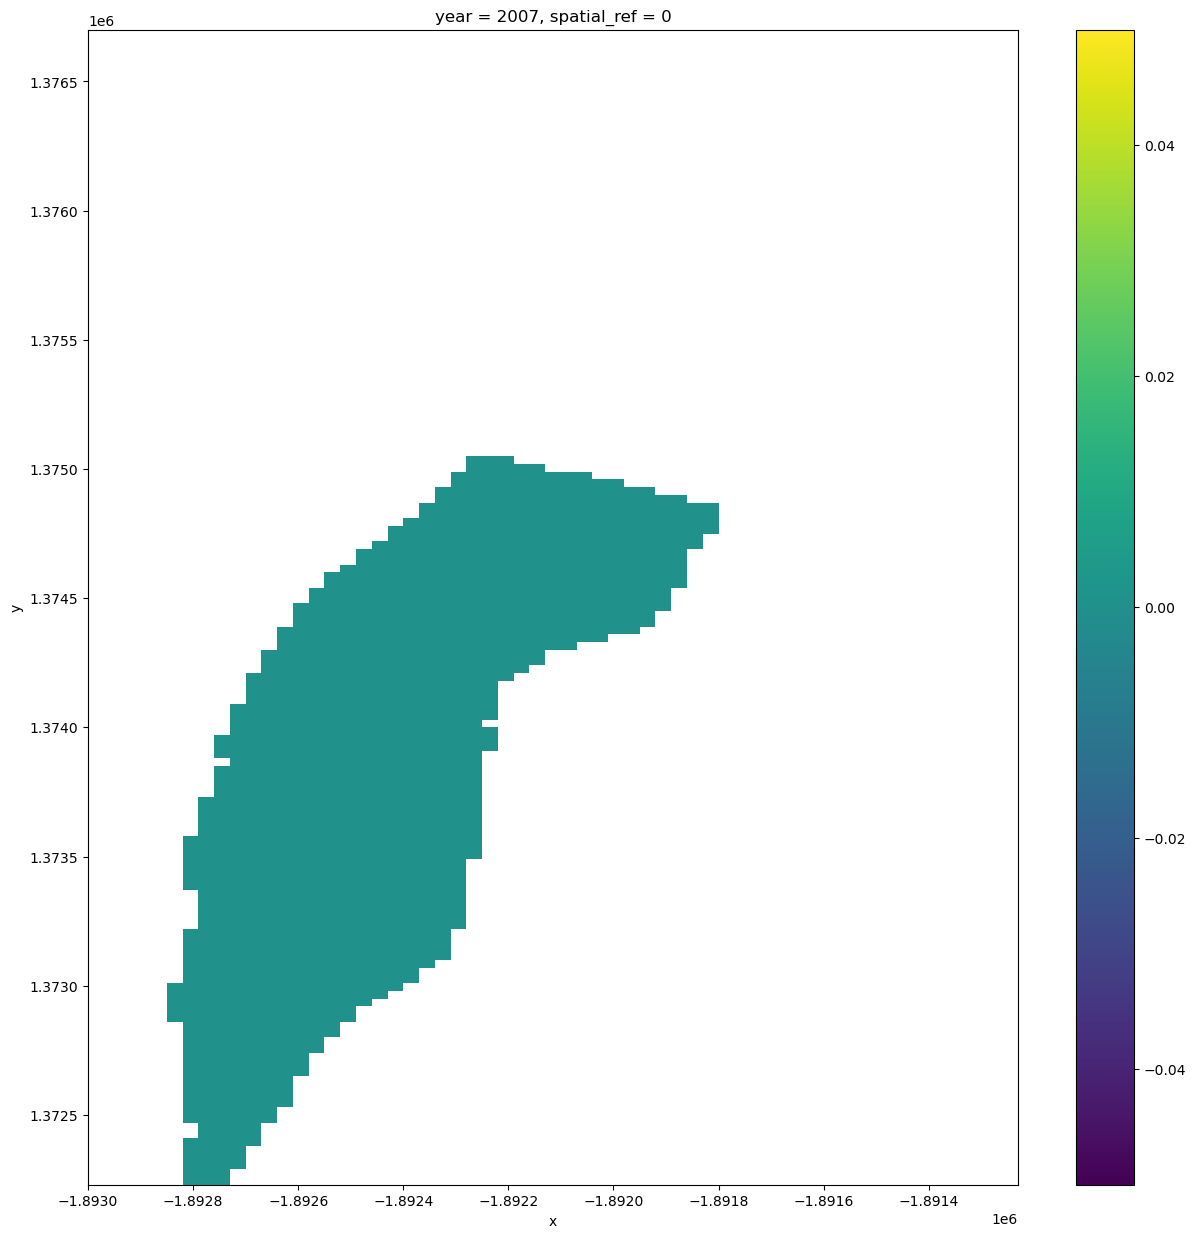

In [9]:
# plot single year
y=2007
binary_y = xr_binary.sel(year=str(y))
binary_y = binary_y.where(binary_y<200,np.nan)

fig,axs = plt.subplots(figsize=(15,15))
binary_y.plot(ax=axs)

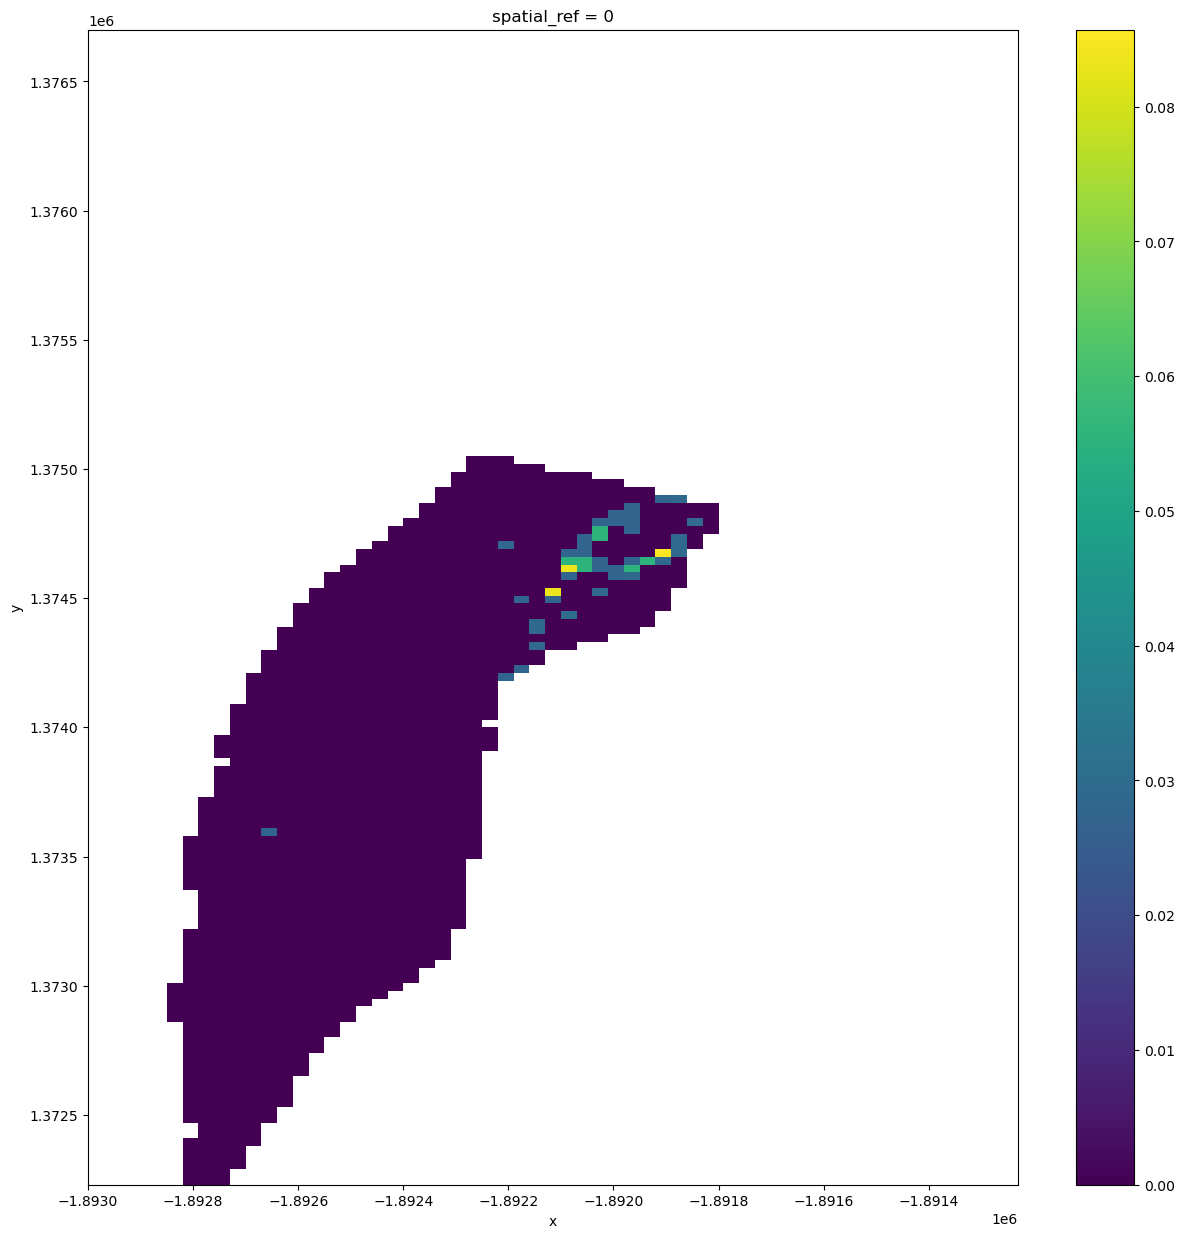

In [8]:
# plot count across all years
temp = xr_binary.where(xr_binary<200, np.nan)
temp = temp.mean(dim='year')

fig,axs = plt.subplots(figsize=(15,15))
temp.plot(ax=axs)